# Overfitting and Regularization

The fundamental issue in machine learning is the tension between optimization and generalization. "Optimization" refers to the process of adjusting a model to get the best performance possible on the training data, while "generalization" refers to how well the trained model would perform on data it has never seen before. The goal of the game is to get good generalization, of course, but you do not control generalization; you can only adjust the model based on its training data.

At the beginning of training, optimization and generalization are correlated: the lower your loss on training data, the lower your loss on test data. While this is happening, your model is said to be under-fit: there is still progress to be made; the network hasn't yet modeled all relevant patterns in the training data. But after a certain number of iterations on the training data, generalization stops improving, validation metrics stall then start degrading: the model is then starting to over-fit, i.e. is it starting to learn patterns that are specific to the training data but that are misleading or irrelevant when it comes to new data.

To prevent a model from learning misleading or irrelevant patterns found in the training data, the best solution is of course to get more training data. A model trained on more data will naturally generalize better. When that is no longer possible, the next best solution is to modulate the quantity of information that your model is allowed to store, or to add constraints on what information it is allowed to store. If a network can only afford to memorize a small number of patterns, the optimization process will force it to focus on the most prominent patterns, which have a better chance of generalizing well.

The processing of fighting overfitting in this way is called regularization. Let's review some of the most common regularization techniques, and let's apply them in practice to improve our movie classification model from the previous chapter.

In this Notebook we will be using the IMDB Dataset to explore some of the possible techniques to deal with overfitting.

As first thing, we import Keras package:

**Import Keras and check the version.**

In [1]:
import keras
keras.__version__

'2.4.3'

## Get the Data

In [1]:
from keras.datasets import imdb
import numpy as np

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)
# Our vectorized labels
y_train = np.array(train_labels).astype('float32')
y_test = np.array(test_labels).astype('float32')

## Overfitting
### Reducing the Network's size

The simplest way to prevent overfitting is to reduce the size of the model, i.e. the number of learnable parameters in the model (which is determined by the number of layers and the number of units per layer). In deep learning, the number of learnable parameters in a model is often referred to as the model's "capacity". Intuitively, a model with more parameters will have more "memorization capacity" and therefore will be able to easily learn a perfect dictionary-like mapping between training samples and their targets, a mapping without any generalization power. For instance, a model with 500,000 binary parameters could easily be made to learn the class of every digits in the MNIST training set: we would only need 10 binary parameters for each of the 50,000 digits. Such a model would be useless for classifying new digit samples. Always keep this in mind: deep learning models tend to be good at fitting to the training data, but the real challenge is generalization, not fitting.

On the other hand, if the network has limited memorization resources, it will not be able to learn this mapping as easily, and thus, in order to minimize its loss, it will have to resort to learning compressed representations that have predictive power regarding the targets -- precisely the type of representations that we are interested in. At the same time, keep in mind that you should be using models that have enough parameters that they won't be underfitting: your model shouldn't be starved for memorization resources. There is a compromise to be found between "too much capacity" and "not enough capacity".

Unfortunately, there is no magical formula to determine what the right number of layers is, or what the right size for each layer is. You will have to evaluate an array of different architectures (on your validation set, not on your test set, of course) in order to find the right model size for your data. The general workflow to find an appropriate model size is to start with relatively few layers and parameters, and start increasing the size of the layers or adding new layers until you see diminishing returns with regard to the validation loss.

Let's try this on our movie review classification network. Our original network was as such:

**Create the following network (call it `original_model`).**

- Dense layer with 16 hidden units and an activation function;
- Dense layer with 16 hidden units and an activation function;
- Dense layer output with an activation function;

In [2]:
from keras import models
from keras import layers

original_model = models.Sequential()
original_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
original_model.add(layers.Dense(16, activation='relu'))
original_model.add(layers.Dense(1, activation='sigmoid'))

2021-12-16 22:11:03.424375: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


**Compile the model.**

In [3]:
original_model.compile(optimizer='rmsprop',
                       loss='binary_crossentropy',
                       metrics=['acc'])

**Now replace it with a smaller network (call it `smaller_model`), with less hidden units instead of 16 and compile it. Be sure to use the same optimizer and loss function of the `original_model`.**

In [4]:
smaller_model = models.Sequential()
smaller_model.add(layers.Dense(4, activation='relu', input_shape=(10000,)))
smaller_model.add(layers.Dense(4, activation='relu'))
smaller_model.add(layers.Dense(1, activation='sigmoid'))

smaller_model.compile(optimizer='rmsprop',
                      loss='binary_crossentropy',
                      metrics=['acc'])

**Fit the original model with 20 epochs and batch size 512. Use x_test and y_test for validation data.**

*Note*: 

Here we use test data as validation data, as our goal is just to compare different techniques against overfitting. 
However, in practice we use validation data (~30% of the data from the training set).
Test data are used for the final evaluation of the model's performance.

In [5]:
original_hist = original_model.fit(x_train, y_train,
                                   epochs=20,
                                   batch_size=512,
                                   validation_data=(x_test,y_test))

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
49/49 [==============================] - ETA: 0s - loss: 0.4721 - acc: 0.8126WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x147907d40> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach t

**Fit the smaller model with 20 epochs and batch size 512. Use x_test and y_test for validation data.**

In [7]:
smaller_model_hist = smaller_model.fit(x_train, y_train,
                                       epochs=20,
                                       batch_size=512,
                                       validation_data=(x_test,y_test))

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
46/49 [===========================>..] - ETA: 0s - loss: 0.6587 - acc: 0.6626WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x149f44560> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach t

**Compare the smaller model with the original one. Fill in the #TO DOs.**

In [8]:
epochs = range(1, 21)
original_val_loss = original_hist.history['val_loss'] # TO DO: take from the history dictionary of the original model the validation loss
smaller_model_val_loss = smaller_model_hist.history['val_loss'] # TO DO: take from the history dictionary of the smaller model the validation loss

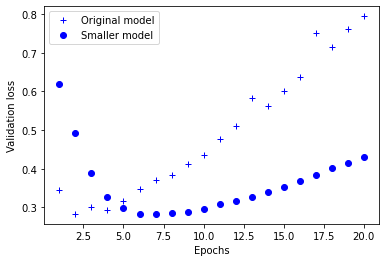

In [9]:
import matplotlib.pyplot as plt

# b+ is for "blue cross"
plt.plot(epochs, original_val_loss, 'b+', label='Original model') # TO DO: use the original model validation loss
# "bo" is for "blue dot"
plt.plot(epochs, smaller_model_val_loss, 'bo', label='Smaller model') # TO DO: use the smaller model validation loss
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

Here's a comparison of the validation losses of the original network and the smaller network. The dots are the validation loss values of the smaller network, and the crosses are the initial network.

**Considerations: what can you conclude from these results? Which of the two network starts to overfitting later? How are their performances?**

As you can see, the smaller network starts overfitting later than the reference one (after 6 epochs rather than 4) and its performance degrades much more slowly once it starts overfitting.

Now, let's add to this benchmark a network that has much more capacity (far more than the problem would warrant).

**Create a bigger network with moe than 16 hidden units (call it `bigger_model`) and compile it.**

In [10]:
bigger_model = models.Sequential()
bigger_model.add(layers.Dense(512, activation='relu', input_shape=(10000,)))
bigger_model.add(layers.Dense(512, activation='relu'))
bigger_model.add(layers.Dense(1, activation='sigmoid'))

bigger_model.compile(optimizer='rmsprop',
                     loss='binary_crossentropy',
                     metrics=['acc'])

**Fit the model with 20 epochs and batch of size 512.**

In [11]:
bigger_model_hist = bigger_model.fit(x_train, y_train,
                                     epochs=20,
                                     batch_size=512,
                                     validation_data=(x_test,y_test))

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
49/49 [==============================] - ETA: 0s - loss: 0.4683 - acc: 0.7925WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x14bf44680> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach t

Let's see how the bigger network fares compared to the reference one. The dots are the validation loss values of the bigger network, and the crosses are the initial network.

**Compare the bigger model with the original one. Fill in the #TO DOs.**

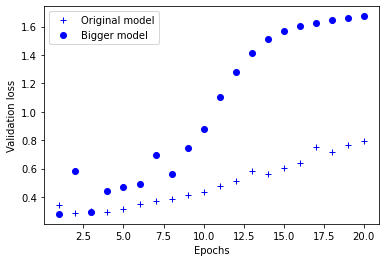

In [12]:
bigger_model_val_loss = bigger_model_hist.history['val_loss'] #TO DO: take from the history dictionary of the bigger model the validation loss

plt.plot(epochs, original_val_loss, 'b+', label='Original model') #TO DO: use the original model validation loss
plt.plot(epochs, bigger_model_val_loss, 'bo', label='Bigger model') #TO DO: use the bigger model validation loss
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

**Considerations: what can you conclude from these results? Which of the two network starts to overfitting later? How are their performances?**

The bigger network starts overfitting almost right away, after just one epoch, and overfits much more severely. Its validation loss is also more noisy.

**Compare the training loss of the bigger model and of the original one. Fill in the #TO DOs.**

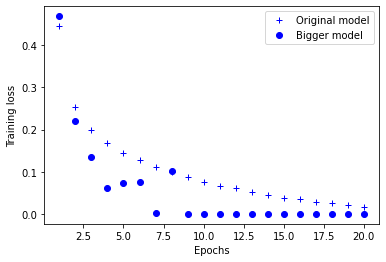

In [13]:
original_train_loss = original_hist.history['loss'] #TO DO: take from the history dictionary of the original model the training loss
bigger_model_train_loss = bigger_model_hist.history['loss'] #TO DO: take from the history dictionary of the bigger model the training loss

plt.plot(epochs, original_train_loss, 'b+', label='Original model') #TO DO: use the original model training loss
plt.plot(epochs, bigger_model_train_loss, 'bo', label='Bigger model') #TO DO: use the smaller model training loss
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.legend()

plt.show()

**Considerations: what can you conclude from these results? How are their performances?**

As you can see, the bigger network gets its training loss near zero very quickly. The more capacity the network has, the quicker it will be able to model the training data (resulting in a low training loss), but the more susceptible it is to overfitting (resulting in a large difference between the training and validation loss).

## Adding weight regularization
Given some training data and a network architecture, there are multiple sets of weights values (multiple models) that could explain the data, and simpler models are less likely to overfit than complex ones.

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters altogether, as we saw in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights to only take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two ways:

- L1 regularization, where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).
- L2 regularization, where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the "L2 norm" of the weights). 

In Keras, weight regularization is added by passing [weight regularizer](https://keras.io/api/layers/regularizers/#layer-weight-regularizers) instances to layers as keyword arguments. Let's add L2 weight regularization to our movie review classification network.

**Consider your original network and add L2 regularizer and try out some regularization coefficient.**

Example: L2 with 0.001 means that every coefficient in the weight matrix of the layer will add 0.001 * weight_coefficient_value to the total loss of the network. Note that because this penalty is only added at training time, the loss for this network will be much higher at training than at test time.

In [14]:
from keras import regularizers

l2_model = models.Sequential()
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu', input_shape=(10000,)))
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu'))
l2_model.add(layers.Dense(1, activation='sigmoid'))

**Compile the network.**

In [15]:
l2_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['acc'])

**Fit the model and check which impact your L2 regularizer has.**

In [16]:
l2_model_hist = l2_model.fit(x_train, y_train,
                             epochs=20,
                             batch_size=512,
                             validation_data=(x_test,y_test))

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
48/49 [============================>.] - ETA: 0s - loss: 0.4918 - acc: 0.8219WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x14cf374d0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach t

**Fill in the #TO DOs to see your results in the plot.**

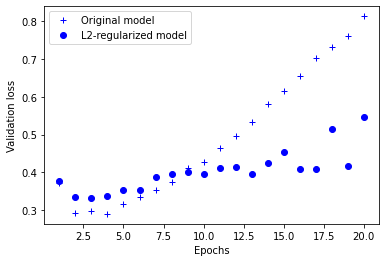

In [17]:
l2_model_val_loss = l2_model_hist.history['val_loss'] #TO DO: take from the take from the history dictionary of the regularized model the validation loss

plt.plot(epochs, original_val_loss, 'b+', label='Original model') #TO DO: use the original model validation loss
plt.plot(epochs, l2_model_val_loss, 'bo', label='L2-regularized model') #TO DO: use the regularized model validation loss
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

**Considerations: what can you conclude from the plot? What about the overfitting?**

As you can see, the model with L2 regularization (dots) has become much more resistant to overfitting than the reference model (crosses), even though both models have the same number of parameters.

As alternatives to L2 regularization, you could use one of the following Keras weight regularizers:

```` 
from keras import regularizers

# L1 regularization
regularizers.l1(0.001)

# L1 and L2 regularization at the same time
regularizers.l1_l2(l1=0.001, l2=0.001)
```` 

## Adding dropout
Dropout is one of the most effective and most commonly used regularization techniques for neural networks. Dropout, applied to a layer, consists of randomly "dropping out" (i.e. setting to zero) a number of output features of the layer during training. Let's say a given layer would normally have returned a vector [0.2, 0.5, 1.3, 0.8, 1.1] for a given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. [0, 0.5, 1.3, 0, 1.1]. The "dropout rate" is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to balance for the fact that more units are active than at training time.

Consider a Numpy matrix containing the output of a layer, layer_output, of shape (batch_size, features). At training time, we would be zero-ing out at random a fraction of the values in the matrix.

````
# At training time: we drop out 50% of the units in the output
#layer_output *= np.randint(0, high=2, size=layer_output.shape)

batch_size = 512
features = 10

layer_output = np.array([batch_size, features])
layer_output = np.random.randint(0, high=2, size=layer_output.shape)
````

At test time, we would be scaling the output down by the dropout rate. Here we scale by 0.5 (because we were previous dropping half the units):

````
# At test time:
layer_output = layer_output*0.5
````

Note that this process can be implemented by doing both operations at training time and leaving the output unchanged at test time, which is often the way it is implemented in practice:

````
# At training time:
layer_output *= np.random.randint(0, high=2, size=layer_output.shape)

# Note that we are scaling *up* rather scaling *down* in this case
layer_output /= 0.5
````

The core idea is that introducing noise in the output values of a layer can break up happenstance patterns that are not significant (what Hinton refers to as "conspiracies"), which the network would start memorizing if no noise was present.

Let's add two [Dropout layers](https://keras.io/api/layers/regularization_layers/dropout/) in our IMDB network to see how well they do at reducing overfitting:

**Add Dropout to the original network. Where should you add the `Dropout` layers? Check Keras documentation and try to understand. Try out different value for the dropout rate.**

In [17]:
dpt_model = models.Sequential()
dpt_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(16, activation='relu'))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(1, activation='sigmoid'))

**Compile the model.**

In [18]:
dpt_model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])

**Fit the model.**

In [19]:
dpt_model_hist = dpt_model.fit(x_train, y_train,
                               epochs=20,
                               batch_size=512,
                               validation_data=(x_test,y_test))

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
46/49 [===========================>..] - ETA: 0s - loss: 0.5990 - acc: 0.6731WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x14d3a37a0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach t

**Fill in the #TO DOs to plot the results.**

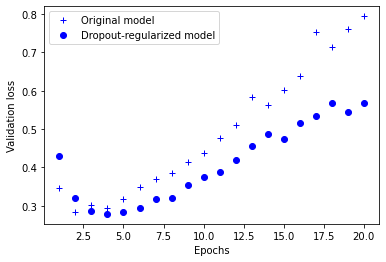

In [20]:
dpt_model_val_loss = dpt_model_hist.history['val_loss'] #TO DO: take from the history dictionary of the model with dropout the validation loss

plt.plot(epochs, original_val_loss, 'b+', label='Original model') #TO DO: use the validation loss of the original model
plt.plot(epochs, dpt_model_val_loss, 'bo', label='Dropout-regularized model') #TO DO: use the validation loss of the model with dropout
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

**Considerations: were you able to improve?**

Again, a clear improvement over the reference network.

**To recap**: 
Here the most common ways to prevent overfitting in neural networks:

- Getting more training data/ Data augmentation
- Reducing the capacity of the network
- Adding weight regularization
- Adding dropout
- Early stopping